In [1]:
import numpy as np
from cpymad.madx import Madx
import sixtracklib as pystlib
import pysixtrack
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from PyHEADTAIL.trackers.rf_bucket import RFBucket


PyHEADTAIL v1.14.1




In [2]:
import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [3]:
from PyHEADTAIL.particles import generators

from PyHEADTAIL.particles.generators import (
    generate_Gaussian6DTwiss, gaussian2D, 
    cut_distribution, make_is_accepted_within_n_sigma)

In [4]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [5]:
# prepare madx
madx = Madx()
madx.options.echo = False
madx.options.warn = False
madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.06.10 13:54:24      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [6]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3

A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

In [7]:
madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot)

True

In [8]:
madx.call(file="SIS100_RF_220618_9slices.thin.seq")

In [9]:
madx.use(sequence='sis100ring')

In [11]:
def prepareMax(qx,qy, A, Q, Etot):
    # prepare madx
    
    madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot)
    madx.call(file="SIS100_RF_220618_9slices.thin.seq")
    madx.use(sequence='sis100ring')

    madx.input('''
    match, sequence=SIS100RING;
    global, sequence=SIS100RING, q1={qx}, q2={qy};
    vary, name=kqf, step=0.00001;
    vary, name=kqd, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
    '''.format(qx=qx, qy=qy))
    
    #install_apertures=True
    
    
    twiss = madx.twiss()
    
    madx.input('cavity_voltage = 58.2/1000/number_cavities;')
    
    return twiss

In [12]:
def setup_pysixtrack():
    
        seqname = 'sis100ring'
        sis100 = getattr(madx.sequence, seqname)
        
        pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
            madx.sequence.sis100ring, exact_drift=True, install_apertures=True)

        pysixtrack_elements.remove_zero_length_drifts(inplace=True);
        pysixtrack_elements.merge_consecutive_drifts(inplace=True);
        
        return pysixtrack_elements
    

In [13]:
def prepareDis(twiss, npart, closed_orbit):
        
    epsx_rms_fin = 35e-6 / 4 # geometrical emittances
    epsy_rms_fin = 15e-6 / 4

    limit_n_rms_x = 2
    limit_n_rms_y = 2
    limit_n_rms_z = 3.4

    sigma_z = 58 / 4. # in m
    sig_dp = 0.5e-3
    
    epsx_gauss = epsx_rms_fin * 1.778
    epsy_gauss = epsy_rms_fin * 1.82

    epsn_x = epsx_gauss * beta * gamma
    epsn_y = epsy_gauss * beta * gamma

    beta_z = sigma_z / sig_dp
    
    if closed_orbit is not None:
        x_co = twiss[0]['x']
        y_co = twiss[0]['y']
    else:
        x_co = 0
        y_co = 0
    
    np.random.seed(0)
    D_x_0 = twiss[0]['dx'] * beta
    D_y_0 = twiss[0]['dy'] * beta

    Dp_x_0 = twiss[0]['dpx'] * beta
    Dp_y_0 = twiss[0]['dpy'] * beta
    
    bx_0 = twiss[0]['betx']
    by_0 = twiss[0]['bety']

    s0 = twiss[-1]['s']
    circumference = s0

    alfx_0 = twiss[0]['alfx']
    alfy_0 = twiss[0]['alfy']

    pyht_beam = generators.generate_Gaussian6DTwiss(
        npart, 1, charge, mass, s0, gamma,
        alfx_0, alfy_0, bx_0, by_0,
        1, epsn_x, epsn_y, 1,
        dispersion_x=None,
        dispersion_y=None,
        limit_n_rms_x=limit_n_rms_x**2, limit_n_rms_y=limit_n_rms_y**2, 
        limit_n_rms_z=limit_n_rms_z**2,
            )

    distribution_z_uncut = generators.gaussian2D(sigma_z**2)
    is_accepted = generators.make_is_accepted_within_n_sigma(
        epsn_rms=sigma_z,
        limit_n_rms=2.5,
    )
    distribution_z_cut = generators.cut_distribution(distribution_z_uncut, is_accepted)

    z, dp = distribution_z_cut(npart)
    pyht_beam.z, pyht_beam.dp = z, dp / beta_z

    # recentre on 0 to avoid dipolar motion:
    pyht_beam.x -= pyht_beam.mean_x()
    pyht_beam.xp -= pyht_beam.mean_xp()
    pyht_beam.y -= pyht_beam.mean_y()
    pyht_beam.yp -= pyht_beam.mean_yp()
    pyht_beam.z -= pyht_beam.mean_z()
    pyht_beam.dp -= pyht_beam.mean_dp()

    # PyHT generates around 0, need to offset with closed orbit:
    pyht_beam.x += x_co
    pyht_beam.y += y_co
    # add dispersive contribution to coordinates:
    pyht_beam.x += D_x_0 * pyht_beam.dp
    pyht_beam.y += D_y_0 * pyht_beam.dp
    # also need to add D'_{x,y} to momenta:
    pyht_beam.xp += Dp_x_0 * pyht_beam.dp
    pyht_beam.yp += Dp_y_0 * pyht_beam.dp
    
    return pyht_beam

In [14]:
def plotDis(pyht_beam):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    plt.sca(ax[0])
    plt.title('horizontal')
    plt.scatter(pyht_beam.x[::100] * 1e3, pyht_beam.xp[::100] * 1e3, s=10, marker='.')
    plt.xlim(1.1*pyht_beam.x.min() * 1e3, 1.1*pyht_beam.x.max() * 1e3)
    plt.ylim(1.1*pyht_beam.xp.min() * 1e3, 1.1*pyht_beam.xp.max() * 1e3)
    plt.xlabel('$x$ [mm]')
    plt.ylabel("$x'$ [mrad]")

    plt.sca(ax[1])
    plt.title('vertical')
    plt.scatter(pyht_beam.y[::100] * 1e3, pyht_beam.yp[::100] * 1e3, s=10, marker='.')
    plt.xlim(1.1*pyht_beam.y.min() * 1e3, 1.1*pyht_beam.y.max() * 1e3)
    plt.ylim(1.1*pyht_beam.yp.min() * 1e3, 1.1*pyht_beam.yp.max() * 1e3)
    plt.xlabel('$y$ [mm]')
    plt.ylabel("$y'$ [mrad]")

    plt.sca(ax[2])
    plt.title('longitudinal')
    plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100] * 1e3, s=10, marker='.')
    plt.xlabel('$z$ [m]')
    plt.ylabel(r"$\Delta p/p_0'$ [$10^{-3}$]")
    plt.tight_layout()
    plt.savefig('phasespace.png')

In [15]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004030406343        15.75163295 

                q1                dq1            betxmax              dxmax 
       18.87796743       -39.96690238          20.300625         3.10542253 

             dxrms             xcomax             xcorms                 q2 
       1.375646097                  0                  0        18.79921581 

               dq2            betymax              dymax              dyrms 
      -39.78794211        20.23624613                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [16]:
closed_orbit = None
pyht_beam = prepareDis(twiss, int(1e6), closed_orbit)

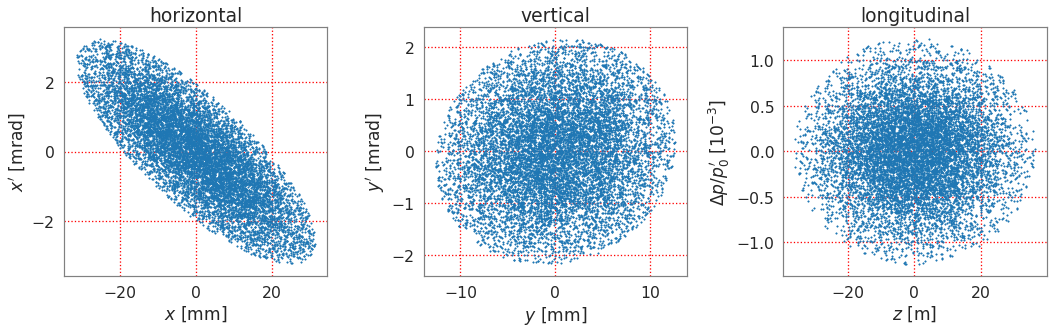

In [17]:
plotDis(pyht_beam)

In [18]:
def tuneFFT(x, y, twiss):
    
    q1mad = twiss.summary['q1']
    q2mad = twiss.summary['q2']
    
    ff = np.linspace(0, 0.5, nturns // 2 + 1)
    xf = abs(np.fft.rfft(x))
    q1st = ff[xf.argmax()]
    
    yf = abs(np.fft.rfft(y))
    q2st = ff[yf.argmax()] 
    #
    q1madFrac = q1mad % 1
    q1madFrac = q1madFrac if q1madFrac < 0.5 else 1 - q1madFrac
    
    q2madFrac = q2mad % 1
    q2madFrac = q2madFrac if q2madFrac < 0.5 else 1 - q2madFrac
    #
    
    #
    print('horizontal:', q1mad, round(1 - q1st,2), q1madFrac - q1st)
    print('vertical:', q2mad, round(1 - q2st,2), q2madFrac - q2st)
    
    return 1 - q1st, 1- q2st

    

In [31]:
def setup_sixtracklib(pysixtrack_elements, pyht_beam, nturns):
    
    elements = pystlib.Elements.from_line(pysixtrack_elements)
    elements.BeamMonitor(num_stores=nturns);
    particles = pystlib.Particles.from_ref(npart, p0c=p0c, mass0 = A*nmass*1e9, q0 =Q)
    
    particles.x[:] = pyht_beam.x
    particles.px[:] = pyht_beam.xp
    particles.y[:] = pyht_beam.y
    particles.py[:] = pyht_beam.yp
    particles.zeta[:] = pyht_beam.z
    particles.delta[:] = pyht_beam.dp

    particles.rpp[:] = 1. / (pyht_beam.dp + 1)

    restmass = mass * c**2
    restmass_sq = restmass**2
    E0 = np.sqrt((p0 * c)**2 + restmass_sq)
    p = p0 * (1 + pyht_beam.dp)
    E = np.sqrt((p * c)**2 + restmass_sq)
    particles.psigma[:] = (E - E0) / (beta * p0 * c)

    gammai = E / restmass
    betai = np.sqrt(1 - 1. / (gammai * gammai))
    particles.rvv[:] = betai / beta
    
    ### prepare trackjob in SixTrackLib
    job = pystlib.TrackJob(elements, particles)
    
    return job
    

In [23]:
def setup_sixtracklib_fft(pysixtrack_elements, nturns, npart):
    elements = pystlib.Elements.from_line(pysixtrack_elements)

    elements.BeamMonitor(num_stores=nturns);

    particles = pystlib.Particles.from_ref(npart, p0c=p0c)

    particles.x += np.linspace(0, 1e-6, npart)
    particles.y += np.linspace(0, 1e-6, npart)

    job = pystlib.TrackJob(elements, particles)
    
    return job
    

In [28]:
def getData(job):
    x = job.output.particles[0].x[1::npart]
    y = job.output.particles[0].y[1::npart]
    #self.madx.exit()

In [35]:
#qx_list = np.arange(18.55, 18.65 + 0.01, 0.01)
#qy_list = qx_list
qy_list = [18.73, 18.74]
qx_list = [18.84, 18.85]

npart = 10  #int(1e6)
nturns = 2**14
closed_orbit = None


tune_fft1 = []
tune_fft2 = []

for qx in qx_list:
    for qy in qy_list:    
        
        twiss = prepareMax(qx, qy, A, Q, Etot)
        
        pysixtrack_elements = setup_pysixtrack()
        
        pyht_beam = prepareDis(twiss, npart, closed_orbit)
        job =  setup_sixtracklib(pysixtrack_elements, pyht_beam, nturns)
        
        # random beam for tune check with fft
        #job = setup_sixtracklib_fft(pysixtrack_elements, nturns, npart )
        
        #job = pystlib.TrackJob(elements, particles, device='opencl:0.0')

        job.track_until(nturns)


        job.collect()

        x = job.output.particles[0].x[1::npart]
        y = job.output.particles[0].y[1::npart]

        q1st, q2st = tuneFFT(x, y, twiss)

        tune_fft1.append(round(q1st,2))
        tune_fft2.append(round(q2st,2))
    


START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   4.21618745e-16





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.80985e-01  2.81561e-01 -1.00000e+20  1.00000e+20
kqd                      -2.79771e-01 -2.80530e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   4.21618745e-16
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0      0.00405008198        15.71332499 

                q1 

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004044525763        15.72411448 

                q1                dq1            betxmax              dxmax 
             18.85       -39.83728443        20.18835429        3.130675374 

             dxrms             xcomax             xcorms                 q2 
       1.382732297                  0                  0              18.73 

               dq2            betymax              dymax              dyrms 
      -39.61659617        20.22588443                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [36]:
print(tune_fft1, tune_fft2)

[0.84, 0.84, 0.85, 0.85] [0.73, 0.74, 0.73, 0.74]
